In [84]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from itertools import combinations
from scipy import stats

from news_vec.corpus import Corpus

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
corpus = Corpus('../data/clf-headlines.json/')

2018-12-28 17:11:14,547 | INFO : Reading headlines.
1225511it [00:17, 69596.50it/s] 


In [264]:
domains = corpus.df.domain.unique()

In [266]:
pairs = list(combinations(domains, 2))

In [271]:
rows = []

for d1, d2 in pairs:

    df = corpus.sample_ab(d1, d2)

    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(1,3)
    )

    df_train, df_test = train_test_split(df)

    X_train = tv.fit_transform(df_train.clf_tokens)
    X_test = tv.transform(df_test.clf_tokens)

    fit = clf.fit(X_train, df_train.domain)

    df_test = df_test.copy()
    df_test['pred'] = fit.decision_function(X_test)
    df_test['pred_true'] = df_test[['domain', 'pred']].apply(lambda x: x[1] if x[0]==fit.classes_[1] else -x[1], 1)

    ddf = df_test[df_test.domain==d1]
    corr, p = stats.pearsonr(-ddf.pred_true, np.log(ddf.impressions))
    rows.append((d1, d2, corr, p))
    print(f'{d1}->{d2}', corr, p)
    
    ddf = df_test[df_test.domain==d2]
    corr, p = stats.pearsonr(-ddf.pred_true, np.log(ddf.impressions))
    rows.append((d2, d1, corr, p))
    print(f'{d2}->{d1}', corr, p)

bloomberg.com->wsj.com 0.004236374758757884 0.7290898209200413
wsj.com->bloomberg.com 0.032378653284348566 0.00783265558912425
bloomberg.com->cnn.com 0.0731295406518773 2.125734283332672e-09
cnn.com->bloomberg.com 0.010333592894945974 0.3962762547777554
bloomberg.com->buzzfeed.com 0.08337463336719539 8.611284042435842e-12
buzzfeed.com->bloomberg.com 0.09276980581537413 2.2849594390453974e-14
bloomberg.com->sputniknews.com 0.04122643138713589 0.0007088007534188289
sputniknews.com->bloomberg.com 0.0029183607926811894 0.8114140899324978
bloomberg.com->huffingtonpost.com 0.06456244970395507 1.1766389694265974e-07
huffingtonpost.com->bloomberg.com -0.010107824003205536 0.40775820421701847
bloomberg.com->nytimes.com 0.058473239388606435 2.0455597778430147e-06
nytimes.com->bloomberg.com 0.011935759022713172 0.3235398240866707
bloomberg.com->breitbart.com 0.03193592534033432 0.008805583864909075
breitbart.com->bloomberg.com -0.08308079364532588 9.592415148639407e-12
bloomberg.com->foxnews.com 

In [272]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'corr', 'p'))

In [274]:
df['label'] = df.apply(lambda r: f'{r.d1} -> {r.d2}', 1)

In [294]:
df[df.d1=='huffingtonpost.com'].sort_values('corr', ascending=False)

,d1,d2,corr,p,label
142,huffingtonpost.com,dailykos.com,0.142421,1.021574e-31,huffingtonpost.com -> dailykos.com
140,huffingtonpost.com,thehill.com,0.130775,4.286559e-27,huffingtonpost.com -> thehill.com
146,huffingtonpost.com,dailycaller.com,0.123634,3.521638e-24,huffingtonpost.com -> dailycaller.com
134,huffingtonpost.com,foxnews.com,0.083524,6.112070e-12,huffingtonpost.com -> foxnews.com
136,huffingtonpost.com,apnews.com,0.071873,3.680926e-09,huffingtonpost.com -> apnews.com
132,huffingtonpost.com,breitbart.com,0.071115,5.887511e-09,huffingtonpost.com -> breitbart.com
63,huffingtonpost.com,cnn.com,0.052679,1.518220e-05,huffingtonpost.com -> cnn.com
138,huffingtonpost.com,washingtonpost.com,0.042253,5.365702e-04,huffingtonpost.com -> washingtonpost.com
144,huffingtonpost.com,npr.org,-0.004919,6.874965e-01,huffingtonpost.com -> npr.org
109,huffingtonpost.com,sputniknews.com,-0.005568,6.480692e-01,huffingtonpost.com -> sputniknews.com


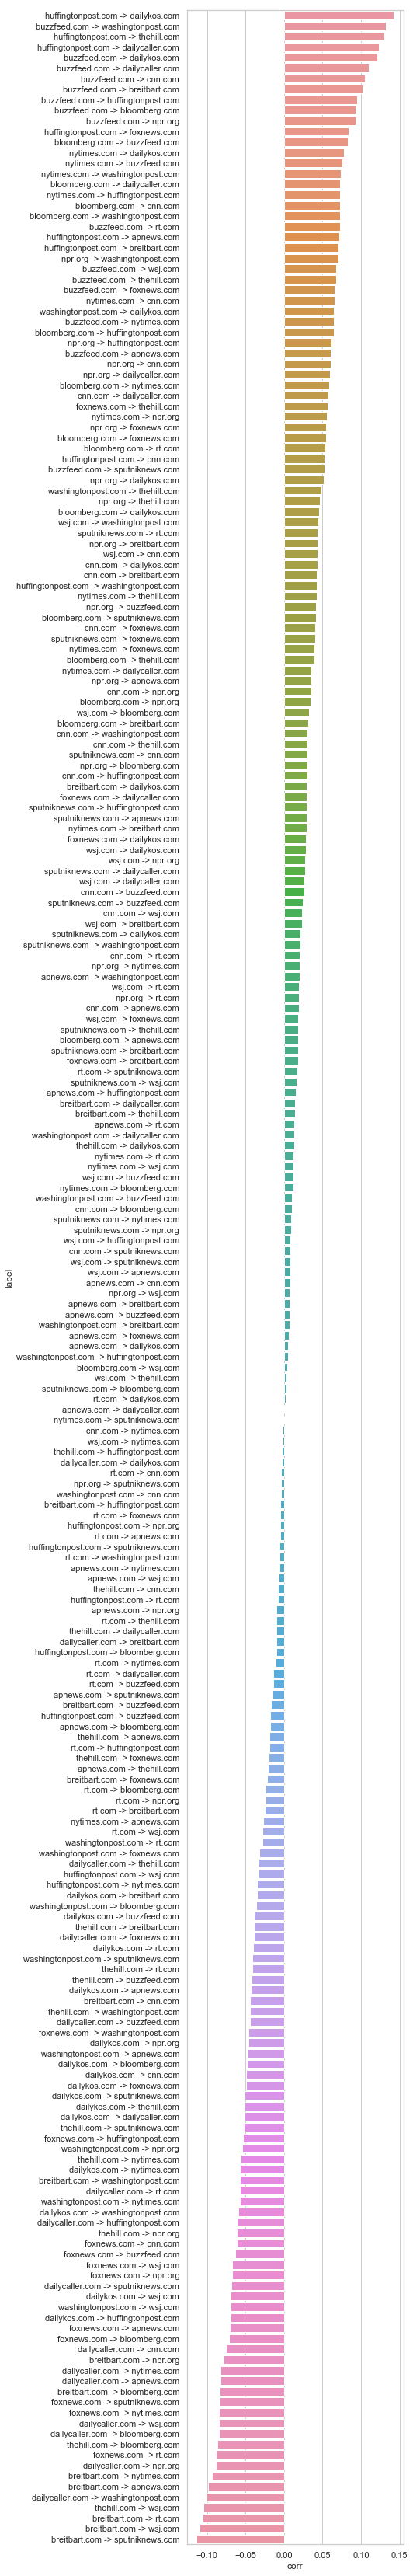

In [280]:
plt.figure(figsize=(5,60))
sns.barplot(x='corr', y='label', data=df.sort_values('corr', ascending=False))